In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random

import numpy as np
from scipy.stats import entropy
import json
import collections
import itertools

import powerlaw
from jointpdf.jointpdf import JointProbabilityMatrix
from jointpdf.jointpdf import FullNestedArrayOfProbabilities

from extension_probability_matrix import JointProbabilityMatrixExtended
import probability_distributions
from probability_distributions import ProbabilityArray
from simulate import find_mean_std_mse
import nudge
import plotting

import information_theory
from information_theory import calculate_mutual_information

import nudge_new
import maximum_nudges

In [3]:
def generate_distribution(shape, method, arguments=None):
    if method=='random_biased':
        distribution = np.random.random(shape)
        distribution = distribution/np.sum(distribution)
        return distribution
    elif method=='random_dirichlet':
        return probability_distributions.compute_joint_uniform_random(shape)
    elif method=='fixed_entropy':
        return probability_distributions.generate_probability_distribution_with_certain_entropy(
            shape, arguments['entropy_size']
        )
    else:
        raise ValueError('provide a valid method')
        
def calculate_amount_and_size_nudges(total_nudge_size, number_of_states, threshold=10):
    """
    Calculate the nudge size and the number of nudges that need to be performed 
    to nudge a variable with the total nudge size. Assuming the distribution is
    not too peaked, in other words, not too many states should have a probability
    that is 10 times smaller than normal.
    
    Parameters:
    ----------
    total_nudge_size: a number
        How much the variable need to be nudged
    number_of_states: a number
        The total number of states of the joint distribution
    threshold: a float 
        Indicating how much smaller than uniform the value of the number
        at the 95-99 percentile of points is. Defaults to 10 
        
    Returns: local_nudge, number_of_nudges
    -------
    local_nudge: a number 
        The size of the local nudge to be performed on the joint distribution
    number_of_nudges: integer
        How often the nudge need to be performed
    
    """
    assumed_min_size = 1.0/threshold
    max_local_nudge = min(total_nudge_size, 0.1/number_of_states)
    number_of_nudges = int(np.ceil(total_nudge_size/max_local_nudge))
    local_nudge = total_nudge_size/float(number_of_nudges) 
    return local_nudge, number_of_nudges

def percentage_max_entropy(shape, percentage):
    """ 
    Return the percentage of the max-entropy given the shape
    
    Parameters:
    ----------
    shape: iterable
    percentage: float
    
    """
    return np.log2(reduce(lambda x,y: x*y, shape)) * percentage

def percentage_states_max_entropy(shape, percentage):
    """ 
    Return the percentage of the max-entropy given the shape
    
    Parameters:
    ----------
    shape: iterable
    percentage: float
    
    """
    return np.log2(reduce(lambda x,y: x*y, shape) * percentage)





Make one cell for plotting

In [4]:
import matplotlib.pyplot as plt

def plot_mean_and_confidence(plot_range, mean, mean_label, confidence_interval, 
                             confidence_interval_title):
    """
    Plot the mean and some kind of confidence interval (standard deviation or
    mean-squared-error)
    
    Parameters:
    ----------
    plot_range: iterable
    mean: an iterable
        the mean of the values at that point
    confidence_interval: an iterable
        Representing the  interval of confidence in that point. 
        The iterable should have length plot_range.
    confidence_interval_title: a string
    
    """
    
    lower_bound = np.array(mean)-np.array(confidence_interval)
    upper_bound = np.array(mean)+np.array(confidence_interval)
    plt.plot(plot_range, mean, label=mean_label)
    plt.fill_between(plot_range, lower_bound, upper_bound, 
                     label='{}'.format(confidence_interval_title),
                     alpha=0.2)
    
def plot_results(*args, **kwargs):
    """plot results from simulations
    
    Parameters:
        args: 1 or more dicts. The dicts should have for the keys numerical
            input values and for the values iterables of numbers.
        kwargs: at least the arguments xlabel, ylabel, title
        
    """
    for argument in args:
        data, meta_dict = argument
        variable_range, mean, std, batches_std = (
            find_mean_std_mse(data, 10)
        )
        
        if kwargs['std_of_batches']: 
            plot_mean_and_confidence(variable_range, mean, meta_dict['mean_label'], 
                                     batches_std, "batches stdev")
        else:
            plot_mean_and_confidence(variable_range, mean, meta_dict['mean_label'], 
                                     std, "batches stdev")
    
    plt.xlabel(kwargs['xlabel'])
    plt.ylabel(kwargs['ylabel'])
    plt.legend()
    plt.title(kwargs['title'])
    plt.show()

        



## Experiment 1

Check the distance between a Dirichlet distribution and the uniform distribution for an 
increasing number of states.  
 

In [5]:
SAMPLE_SIZE = 1000
min_number_of_states = 2
max_number_of_states = 250

entropies_dirichlet = []
for i in range(min_number_of_states, max_number_of_states, 1):
    distances = []
    for _ in range(SAMPLE_SIZE):
        dirichlet_dist = np.random.dirichlet([1]*i)
        #print(dirichlet_dist)
        distance = entropy(dirichlet_dist, base=2)
        distances.append(distance)
    
    entropies_dirichlet.append(np.mean(distances))
    
print(entropies_dirichlet)
    

[0.72796092165768855, 1.1966011378651769, 1.5540368838931808, 1.8442217805559904, 2.0885981448614483, 2.2820284528837016, 2.4691461576507296, 2.6479747730907603, 2.7905086651147304, 2.9142831752869549, 3.0437849545115632, 3.1488330007809924, 3.2483987999065849, 3.3444644148242206, 3.4338631763511938, 3.512809146018296, 3.6009932080789824, 3.6767648583382591, 3.7525834962104136, 3.8198052027010072, 3.876073899442861, 3.931713029219738, 4.0126659149558481, 4.0604426318578284, 4.1179811262604158, 4.1771474176841803, 4.2279432127045826, 4.2705638560697423, 4.3270898530045594, 4.3695774101677616, 4.407336651472062, 4.4539609081935376, 4.5056324466152562, 4.5460579771447627, 4.5811534955280102, 4.6213160172846868, 4.6571526237434222, 4.6952168052745966, 4.7332664453851976, 4.7619486042415629, 4.8030125901772394, 4.8339328573246805, 4.8624715836457835, 4.9031840251724077, 4.9277034231550187, 4.9606645117851285, 4.984241212288814, 5.0151590321228889, 5.0485041050729089, 5.0806462060590185, 5.1

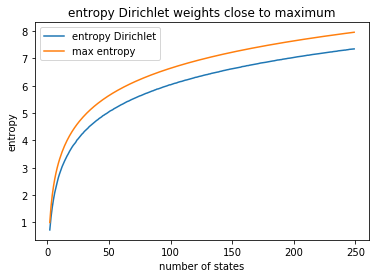

In [7]:
plt.plot(list(range(2,250,1)), entropies_dirichlet, label="entropy Dirichlet")
plt.plot(list(range(2,250,1)), np.log2(list(range(2,250,1))), label="max entropy")
plt.xlabel("number of states")
plt.ylabel("entropy")
plt.title('entropy Dirichlet weights close to maximum')
plt.legend()
plt.show()


### Experiment 2A

See what the distance is between 2 randomly generated functions

Check the average "distance" (KL-divergence) between randomly (probability masses states are distributed according to Dirichlet distribution) generated distributions. The distance decreases, since, the number of
states that are close to uniform increases as the number of states for a distribution grows.

In [ ]:
number_of_states, number_of_variables = 5, 4
shape = tuple([number_of_states]*(number_of_variables+1))
total_nudge_size = 0.01
total_number_of_states = number_of_states**number_of_variables
max_local_nudge, number_of_nudges = calculate_amount_and_size_nudges(
    total_nudge_size, total_number_of_states
)

total_nudge_sizes = []
for i in range(50):
    print(i)
    #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
    distribution = ProbabilityArray(generate_distribution(
        shape, 'fixed_entropy', 
        {"entropy_size":percentage_states_max_entropy(shape, 0.1)}
    ))
    function_labels, label_nudged_variable = set([number_of_variables]), 0
    input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
    input_distribution = distribution.marginalize(input_variable_labels)
    marginal_nudged_old = ProbabilityArray(input_distribution).marginalize(
        set([label_nudged_variable])
    ) 
    
    new_input_distribution = nudge.nudge_distribution_local_non_causal(
        input_distribution, 0, max_local_nudge, number_of_nudges
    )
    marginal_nudged_new = ProbabilityArray(new_input_distribution).marginalize(
        set([label_nudged_variable])
    ) 
    total_nudge_sizes.append(np.sum(np.absolute(marginal_nudged_old-marginal_nudged_new)))
    
print(np.mean(total_nudge_sizes))

In [ ]:
number_of_states, number_of_distributions = 5, 20
difference_distributions = []
for number_of_variables in range(1, 6, 1):
    marginal_outputs = []
    shape = tuple([number_of_states]*(number_of_variables+1))
    for i in range(number_of_distributions):
        print(i)
        #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
        distribution = ProbabilityArray(generate_distribution(
            shape, 'fixed_entropy', 
            {"entropy_size":percentage_max_entropy(shape, 0.75)}
        ))
        function_label, label_nudged_variable = number_of_variables, 0
        marginal_outputs.append(distribution.marginalize(set([function_label])))

    kl_divergences = []
    for i in range(int(number_of_distributions/2.0)):
        kl_divergences.append(entropy(marginal_outputs[i].flatten(), marginal_outputs[i+1].flatten()))

    difference_distributions.append(np.mean(kl_divergences))
    print(np.mean(kl_divergences))

### Experiment 2B 

The actual experiment- for non-causal nudges. Both for local and not local nudges. Local nudges can be performed with vector and focused nudges, while non-local nudges are always vector nudges.

In [ ]:
import copy
    
def product(it):
    """calculate the product of all terms in the iterable"""
    return reduce(lambda x, y: x*y, it)
    
def calculate_focused_nudge_impact(distribution, total_nudge_size):
    """ 
    For now calculate the impact of a local non-causal nudge on the input variables
    on the completely causally determined output variable
    
    Parameters:
    ----------
    distribution: a ProbabilityArray object
    total_nudge_size: number
    
    """
    number_of_variables = len(distribution.probability_distribution.shape)
    total_number_of_states = product(distribution.probability_distribution.shape)
    max_local_nudge, number_of_nudges = calculate_amount_and_size_nudges(
        total_nudge_size, total_number_of_states
    )
    function_labels, label_nudged_variable = set([number_of_variables-1]), 0
    input_variable_labels = set(range(number_of_variables)) - function_labels
    input_distribution = distribution.marginalize(input_variable_labels)
    new_input_distribution = nudge.nudge_distribution_local_non_causal(
        input_distribution, 0, max_local_nudge, number_of_nudges
    )
    return nudge.impact_nudge_causal_output(distribution, function_labels,
                                            new_input_distribution)

def calculate_non_local_nudge_impact(distribution, total_nudge_size, nudged_variables):
    """ 
    Calculate the impact of a non-local non-causal nudge (using a vector-nudge) 
    on the input variables on the completely causally determined output variable
    
    Parameters:
    ----------
    distribution: a ProbabilityArray object
    total_nudge_size: number
    nudged_variables: a list of integers
    
    """
    number_of_variables = len(distribution.probability_distribution.shape)
    function_labels, label_nudged_variable = set([number_of_variables-1]), 0
    input_variable_labels = set(range(number_of_variables)) - function_labels
    input_distribution = distribution.marginalize(input_variable_labels)
    
    new_input_distribution = nudge.nudge_distribution_non_local_non_causal(
        input_distribution, nudged_variables, total_nudge_size, 'random'
    )
    return nudge.impact_nudge_causal_output(distribution, function_labels,
                                            new_input_distribution)

number_of_variables = 5
NUMBER_OF_STATES = 4
TOTAL_NUDGE_SIZE = 0.01
shape = tuple([NUMBER_OF_STATES] * (number_of_variables))
distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
#distribution = ProbabilityArray(generate_distribution(
#    shape, 'fixed_entropy', 
#    {"entropy_size":percentage_max_entropy(shape, 0.7)}
#))

focused_nudge_impact = calculate_focused_nudge_impact(distribution, TOTAL_NUDGE_SIZE)
print(focused_nudge_impact)

nudged_variables = [0] 
vector_nudge_impact = calculate_non_local_nudge_impact(
    distribution, TOTAL_NUDGE_SIZE, nudged_variables
)
print(vector_nudge_impact)



#### Experiment 

Look at differences of impact for local vector and focused nudges

In [ ]:
number_of_variables = 4
NUMBER_OF_STATES = 4
TOTAL_NUDGE_SIZE = 0.01
nudged_variables = [0]
number_of_samples = 100

focused_nudge_impacts = []
vector_nudge_impacts = []
for i in range(number_of_samples):
    if i%10==0:
        print(i)
        
    shape = tuple([NUMBER_OF_STATES] * (number_of_variables))
    #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
    distribution = ProbabilityArray(generate_distribution(
        shape, 'fixed_entropy', 
        {"entropy_size":percentage_max_entropy(shape, 0.7)}
    ))        
    focused_nudge_impact = calculate_focused_nudge_impact(distribution, TOTAL_NUDGE_SIZE)
    focused_nudge_impacts.append(focused_nudge_impact)
    
    vector_nudge_impact = calculate_non_local_nudge_impact(
        distribution, TOTAL_NUDGE_SIZE, nudged_variables
    )
    vector_nudge_impacts.append(vector_nudge_impact)
    
print("mean & std focused nudge {} ({})".format(
    np.mean(focused_nudge_impacts), np.std(focused_nudge_impacts)
))
print("mean & std vector nudge {} ({})".format(
    np.mean(vector_nudge_impacts), np.std(vector_nudge_impacts)
))
differences = np.array(focused_nudge_impacts) - np.array(vector_nudge_impacts)
print("mean & std difference focused minus vector {} ({})".format(
    np.mean(differences), np.std(differences)
))



Experiment:
The impact of a vector/focused nudge on the input variables 
(with no causal impact on the other input variables)
on the output variable, for different number of input variables.


In [ ]:
MAX_NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 5, 5, 0.01
nudged_variables = [0]
NUMBER_OF_SAMPLES = 10

impact_focused_nudge_dict = {}
impact_vector_nudge_dict = {}
for number_of_variables in range(1, MAX_NUMBER_OF_VARIABLES, 1):
    print(number_of_variables)
    focused_nudge_impacts = []
    vector_nudge_impacts = []
    for i in range(NUMBER_OF_SAMPLES):
        if i%5 == 0: 
            print("sample number {}".format(i))
            
        shape = tuple([NUMBER_OF_STATES] * (number_of_variables+1))
        #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
        distribution = ProbabilityArray(generate_distribution(
            shape, 'fixed_entropy', 
            {"entropy_size":percentage_max_entropy(shape, 0.7)}
        ))
        focused_nudge_impact = calculate_focused_nudge_impact(distribution, TOTAL_NUDGE_SIZE)
        focused_nudge_impacts.append(focused_nudge_impact)
        vector_nudge_impact = calculate_non_local_nudge_impact(
            distribution, TOTAL_NUDGE_SIZE, nudged_variables
        )
        vector_nudge_impacts.append(vector_nudge_impact)
    
    impact_focused_nudge_dict[number_of_variables] = focused_nudge_impacts
    impact_vector_nudge_dict[number_of_variables] = vector_nudge_impacts
    #with open("back_up_number_variables_output.json", 'w') as f:
    #    json.dump(impact_nudge_dict, f)

#print(impact_nudge_dict) 


In [ ]:
plot_results(
    (impact_focused_nudge_dict, {'mean_label': 'focused'}), 
    (impact_vector_nudge_dict, {'mean_label': 'vector'}),
    xlabel="number of input variables", ylabel = "KL-divergence", 
    title="the impact of the nudge given a number of variables", std_of_batches=False
)
    

#plotting.plot_mean_and_confidence(
#    variable_range, np.array(mean_impact_nudge)/np.array(difference_distributions), batches_std,
#    "std of batched means", xlabel, "normalised impact of the nudge", "normalised values"
#)

#fit = powerlaw.Fit(mean_impact_nudge)
#print(fit.distribution_compare("power_law", "exponential"))
#print(fit.distribution_compare("power_law", "lognormal"))

#### Experiment 2C

Compare local vector nudges to synergistic nudges (nudges on the total distribution)

In [ ]:
MAX_NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 5, 5, 0.01
NUMBER_OF_SAMPLES = 50

impact_local_nudge_dict = {}
impact_synergistic_nudge_dict = {}
for number_of_input_variables in range(1, MAX_NUMBER_OF_VARIABLES, 1):
    print(number_of_input_variables)
    synergistic_nudge_impacts = []
    local_nudge_impacts = []
    for i in range(NUMBER_OF_SAMPLES):
        if i%10 == 0: 
            print("sample number {}".format(i))
            
        nudged_variables = list(range(number_of_input_variables))
        random.shuffle(nudged_variables)
        
        shape = tuple([NUMBER_OF_STATES] * (number_of_input_variables+1))
        #distribution = generate_distribution(shape, 'random_dirichlet')
        distribution = generate_distribution(
            shape, 'fixed_entropy', 
            {"entropy_size":percentage_max_entropy(shape, 0.7)}
        )

        distribution_copy = np.copy(distribution)
        
        distribution = ProbabilityArray(distribution)
        distribution_copy = ProbabilityArray(distribution_copy)
        
        local_nudge_impact = calculate_non_local_nudge_impact(
            distribution, TOTAL_NUDGE_SIZE, [0]
        )
        local_nudge_impacts.append(local_nudge_impact)

        synergistic_nudge_impact = calculate_non_local_nudge_impact(
            distribution_copy, TOTAL_NUDGE_SIZE, [0]
        )
        synergistic_nudge_impacts.append(synergistic_nudge_impact)
        #print("difference local-synergistic {}".format(local_nudge_impact-synergistic_nudge_impact))
        

        
    impact_synergistic_nudge_dict[number_of_input_variables] = synergistic_nudge_impacts
    impact_local_nudge_dict[number_of_input_variables] = local_nudge_impacts
    #with open("back_up_number_variables_output.json", 'w') as f:
    #    json.dump(impact_nudge_dict, f)



In [ ]:
plot_results(
    (impact_local_nudge_dict, {'mean_label': 'local'}), 
    (impact_synergistic_nudge_dict, {'mean_label': 'synergetic'}),
    xlabel="number of input variables", ylabel = "KL-divergence", 
    title="Compare local and synergetic nudge impacts", std_of_batches=True
)

### Experiment 4:
Change the output so as to minimize the nudge impact. See what happens with the mutual information between
the nudged variable and the output distribution

In [ ]:

def get_nudge_impact(distribution, output_label, nudge_label, number_of_nudges, local_nudge_size):
    input_variable_labels = (set(range(len(distribution.probability_distribution.shape))) -
                             set([output_label]))
    input_distribution = distribution.marginalize(input_variable_labels)
    
    new_input_distribution = nudge.nudge_distribution_local_non_causal(
        input_distribution, nudge_label, local_nudge_size, number_of_nudges
    )
    return nudge.impact_nudge_causal_output(distribution, set([output_label]),
                                      new_input_distribution)

def minimize_nudge_greedy(initial_distribution, output_label, number_of_trials, 
                          evaluations_per_trial, mutation_size, number_of_mutations,
                          total_nudge_size, nudge_label):
    """
    Mutate the distribution to minimize nudge impact and maximize entropy
    
    Parameters:
    ----------
    initial_distribution: a numpy array
        Representing a discrete probability distribution
    function_label: an integer
    nudge_size: a (small) number
    number_of_nudges: an integer
    
    """
    total_number_of_states = reduce(lambda x, y: x*y, initial_distribution.shape)
    local_nudge_size, number_of_nudges = calculate_amount_and_size_nudges(
        total_nudge_size, total_number_of_states
    )
                             
    distribution = initial_distribution
    nudge_impacts = []
    for i in range(evaluations_per_trial):
        nudge_impacts.append(get_nudge_impact(
            ProbabilityArray(initial_distribution), output_label, nudge_label, number_of_nudges, local_nudge_size
        ))                        
    prev_nudge_impact = np.mean(nudge_impacts)
    initial_nudge_impact = prev_nudge_impact
    #print(prev_nudge_impact)
             
    for i in range(number_of_trials):
        #print(i)
        #print("number of mutations {}".format(number_of_mutations))
        proposed_distribution = nudge.mutate_distribution_with_fixed_marginals(
            distribution, output_label, int(number_of_mutations), mutation_size
        ) 
        #print("found proposal distribution")
        nudge_impacts = []
        for j in range(evaluations_per_trial):
            nudge_impacts.append(get_nudge_impact(
                ProbabilityArray(proposed_distribution), output_label, nudge_label,
                number_of_nudges, local_nudge_size
            ))
        if np.mean(nudge_impacts) < prev_nudge_impact:
            prev_nudge_impact = np.mean(nudge_impacts)
            distribution = proposed_distribution
            
        #print(prev_nudge_impact)
    
    return distribution, prev_nudge_impact, initial_nudge_impact, prev_nudge_impact

NUMBER_OF_VARIABLES, NUMBER_OF_STATES = 3, 4 
#pdf = JointProbabilityMatrix(NUMBER_OF_VARIABLES+1, NUMBER_OF_STATES, 'random')
#initial_distribution = pdf.joint_probabilities.joint_probabilities
initial_distribution = generate_distribution(
    shape, 'fixed_entropy', 
    {"entropy_size":percentage_max_entropy(shape, 0.75)}
)

output_label = NUMBER_OF_VARIABLES

number_of_trials = 50
evaluations_per_trial = 10
mutation_size = 0.2 / (4.0**3)
number_of_mutations = int(0.1 * 4**3)
a=minimize_nudge_greedy(initial_distribution, output_label, number_of_trials, 
                      evaluations_per_trial, mutation_size, number_of_mutations, 0.01, 0)

print(a[1])

In [ ]:
NUMBER_OF_VARIABLES, NUMBER_OF_STATES = 4, 4 
output_label = NUMBER_OF_VARIABLES
number_of_trials = 50
evaluations_per_trial = 10
mutation_size = 0.2 / (5.0**4)
number_of_mutations = int(0.1 * 5**4)
number_of_samples = 20

mi_before = []
mi_after = []

impact_before = []
impact_after = []

for count in range(number_of_samples):
    if count%2==0:
        print(count)
        
    shape = [NUMBER_OF_STATES] * (NUMBER_OF_VARIABLES+1)
    #initial_distribution = generate_distribution(shape, 'random_dirichlet')
    initial_distribution = generate_distribution(
        shape, 'fixed_entropy', 
        {"entropy_size":percentage_max_entropy(shape, 0.6)}
    )

    a=minimize_nudge_greedy(initial_distribution, output_label, number_of_trials, 
                          evaluations_per_trial, mutation_size, number_of_mutations, 0.01, 0)

    impact_before.append(a[2])
    impact_after.append(a[3])
    mi_before.append(calculate_mutual_information(
        ProbabilityArray(initial_distribution), set([0]), set([NUMBER_OF_VARIABLES])
    ))
    mi_after.append(calculate_mutual_information(
        ProbabilityArray(a[0]), set([0]), set([NUMBER_OF_VARIABLES])
    ))
    
print("mean impact before {}".format(np.mean(impact_before)))
print("mean impact before {}".format(np.mean(impact_after)))
    
print("mean mi before {}".format(np.mean(mi_before)))
print("mean mi after {}".format(np.mean(mi_after)))

In [ ]:
print(mi_before)
print(mi_after)

Tryout cell to generate a joint with a certain entropy 

In [ ]:
shape = tuple([5, 5, 5, 5, 5])
entropy_size = percentage_states_max_entropy(shape, 0.1)
print(entropy_size)
dist = generate_distribution(shape, method='fixed_entropy', arguments={"entropy_size": entropy_size})
print(entropy(dist.flatten(), base=2))

### Experiment 5 

Now assume that the nudge on the local variable caually impacts the other input variables

In [ ]:
number_of_input_variables = 3
number_of_states = 5
nudge_size = 0.01

input_distribution = generate_distribution()
nudge_labels = [0]
other_input_labels = list(range(1, number_of_input_variables))

def calculate_new_distribution_after_nudge(distribution, nudge_labels, other_variable_labels):
    """
    Perform a nudge on a subset of the variables and assume
    they causally impact the other variables, and return the new
    distribution
    
    Note:
    ----
    If the nudged variables contain 0 states than those states are removed
    from the entire distribution
    
    Parameters:
    ----------
    distribution: a numpy array
    nudge_labels: A list of integers
        The variables that will be nudged
    other_variable_labels: A list of integers
    
    Returns: a numpy array
    -------
    The new distribution
    
    """
    marginal_nudge = ProbabilityArray(distribution).marginalize(set(nudge_labels))
    if np.all(marginal_nudge!=0):
        conditional_on_nudge, other_labels, nudge_labels_old = (
            ProbabilityArray(input_distribution).find_conditional(set(other_labels), set(nudge_labels))
        )
    else:
        #adjust this to multiple nudge on input states
        
        for label in nudge_labels:
            zero_states = [count for count, state in enumerate(marginal_nudge) if state == 0]
            for zero_state in zero_states:
                input_distribution = np.delete(input_distribution, zero_state, nudge_label)

        marginal_nudge = ProbabilityArray(input_distribution).marginalize(set(nudge_labels))
        conditional_on_nudge, other_labels, nudge_labels_old = (
            ProbabilityArray(input_distribution).find_conditional(set(other_input_labels), set(nudge_labels))
        )

    marginal_nudged, nudges_states = nudge.nudge(
        marginal_variable_old, nudge_size
    )
    input_distribution_new = probability_distributions.compute_joint(
        marginal_nudged, conditional_on_nudge, nudge_labels_old
    ) 



### Experiment 6
#### find the maximal local non-causal additive nudge

In [ ]:
def find_nudge_impact(old_input, new_input, conditional_output, measure="absolute"):
    """
    Find the impact of a nudge transforming the old input into
    the new input.
    
    Parameters:
    ----------
    old_input: nd-array
        representing a probability distribution
    new_input: nd-array
        representing a probability distribution
    conditional_output: nd-array
        represening the probability distribution, the last variable
        should be the conditional output (in tree form the leaves should be
        the conditional output)
    measure: string
        Should be in: {"absolute", "kl-divergence"}
        
    Returns: a number
    
    """
    number_of_input_vars = len(old_input.shape)
    old_joint = probability_distributions.compute_joint(
        old_input, conditional_output, set(range(0, number_of_input_vars, 1))
    )
    print("old joint {}".format(old_joint))
    old_output = ProbabilityArray(old_joint).marginalize(set([number_of_input_vars]))
    new_joint = probability_distributions.compute_joint(
        new_input, conditional_output, set(range(0, number_of_input_vars, 1))
    )
    new_output = ProbabilityArray(new_joint).marginalize(set([number_of_input_vars]))
    if measure=="absolute":
        return np.sum(np.absolute(old_output.flatten()-new_output.flatten()))
    elif measure=="kl-divergence":
        return entropy(old_output.flatten(), new_output.flatten(), base=2)
    else:
        raise ValueError("provide a valid measure")
        
old_input = np.array([0.1, 0.2, 0.05, 0.3, 0.35])
new_input = np.array([0.12, 0.18, 0.06, 0.31, 0.33])
cond_output = np.array([
    [0.3, 0.4, 0.3],
    [0.2, 0.5, 0.3],
    [0.15, 0.45, 0.4],
    [0.46, 0.18, 0.36],
    [0.32, 0.43, 0.25]
])
find_nudge_impact(old_input, new_input, cond_output)

    

#### First do it for distributions randomly drawn from the entire space of distributions

In [ ]:
import maximum_nudges
from maximum_nudges import find_maximum_local_nudge
from maximum_nudges import find_max_control_impact
import nudge_new

amount_of_states = 5
amount_of_input_vars = 5
number_of_samples = 50
nudge_size = 0.01

input_vars_to_random_local_impacts = {}
input_vars_to_max_local_impacts = {}
input_vars_to_random_control_impacts = {}
input_vars_to_max_control_impacts = {}
for input_vars in range(1, amount_of_input_vars+1, 1):
    print(input_vars)
    random_local_nudge_impacts = []
    max_local_nudge_impacts = []
    random_control_nudge_impacts = []
    max_control_nudge_impacts = []
    for i in range(number_of_samples):
        shape = [amount_of_states]*(input_vars+1)
        joint_distribution = generate_distribution(shape, "random_dirichlet")
        input_dist = ProbabilityArray(joint_distribution).marginalize(set(list(range(input_vars))))
        cond_output, output_label, input_labels = ProbabilityArray(joint_distribution).find_conditional(
            set([input_vars]), set(list(range(input_vars)))
        )

        #find the nudge impacts
        input_locally_nudged = nudge_new.local_non_causal(input_dist, nudge_size)
        random_local_impact = nudge_new.find_nudge_impact(
            input_dist, input_locally_nudged, cond_output
        )
        random_local_nudge_impacts.append(random_local_impact)
        
        temp_cond_output = np.reshape(cond_output, (amount_of_states**input_vars, amount_of_states))
        #tryout
        max_local_impact1 = maximum_nudges.find_maximum_local_nudge_without_conditional(
            input_dist, temp_cond_output, nudge_size
        )
        max_local_impact = find_maximum_local_nudge(
            input_dist, temp_cond_output, nudge_size
        )
        if abs(max_local_impact-max_local_impact1) > 10**(-7):
            raise ValueError()

        max_local_nudge_impacts.append(max_local_impact)
        
        input_control_nudged = nudge_new.control_non_causal(input_dist, nudge_size)
        random_control_impact = nudge_new.find_nudge_impact(
            input_dist, input_control_nudged, cond_output
        )
        random_control_nudge_impacts.append(random_control_impact)
        
        _, _, max_control_impact = find_max_control_impact(
            input_dist, cond_output, nudge_size
        )
        max_control_nudge_impacts.append(max_control_impact)
        
    input_vars_to_random_local_impacts[input_vars] = random_local_nudge_impacts
    input_vars_to_max_local_impacts[input_vars] = max_local_nudge_impacts
    input_vars_to_random_control_impacts[input_vars] = random_control_nudge_impacts
    input_vars_to_max_control_impacts[input_vars] = max_control_nudge_impacts


In [ ]:
import matplotlib.pyplot as plt

plot_range, mean_random_local, std_random_local, batch_std_random_local = find_mean_std_mse(
    input_vars_to_random_local_impacts, batch_size=5
)
plot_range, mean_max_local, std_max_local, batch_std_max_local = find_mean_std_mse(
    input_vars_to_max_local_impacts, batch_size=5
)
plot_range, mean_random_control, std_random_control, batch_std_random_control = find_mean_std_mse(
    input_vars_to_random_control_impacts, batch_size=5
)
plot_range, mean_max_control, std_max_control, batch_std_max_control = find_mean_std_mse(
    input_vars_to_max_control_impacts, batch_size=5
)

plt.plot(plot_range, mean_random_local, label="random local")
plt.plot(plot_range, mean_max_local, label="max local")
plt.plot(plot_range, mean_random_control, label="random control")
plt.plot(plot_range, mean_max_control, label="max control")
plt.legend()
plt.show()

plt.plot(plot_range, mean_random_local, label="random local")
plt.plot(plot_range, mean_random_control, label="rendom control")

lower_bound_random_local = np.array(mean_random_local)-np.array(std_random_local)
upper_bound_random_local = np.array(mean_random_local)+np.array(std_random_local)
plt.fill_between(plot_range, lower_bound_random_local, upper_bound_random_local, 
                 label='{}'.format("random local std"), alpha=0.2)

lower_bound_random_control = np.array(mean_random_control)-np.array(std_random_control)
upper_bound_random_control = np.array(mean_random_control)+np.array(std_random_control)
plt.fill_between(plot_range, lower_bound_random_control, upper_bound_random_control, 
                 label='{}'.format("random control std"), alpha=0.2)

plt.legend()
plt.show()

#plot_results(
#    (input_vars_to_max_impacts, {'mean_label': 'max_local_nudges'}), 
#    xlabel="number of input variables", ylabel = "absolute impact", 
#    title="maximum local non-causal additive nudges", std_of_batches=False
#)

#### Now do it for distributions with a limited entropy

In [1]:
import maximum_nudges
from maximum_nudges import find_maximum_local_nudge
from maximum_nudges import find_max_control_impact
import nudge_new
import evolutionary_algorithms as ea
from probability_distributions import produce_distribution_with_entropy_evolutionary_old as get_entropy_dist

amount_of_states = 5
amount_of_input_vars = 4
number_of_samples = 5
nudge_size = 0.01
entropy_amount = 0.9

input_vars_to_random_local_impacts = {}
input_vars_to_max_local_impacts = {}
input_vars_to_random_control_impacts = {}
input_vars_to_max_control_impacts = {}
for input_vars in range(1, amount_of_input_vars+1, 1):
    print(input_vars)
    random_local_nudge_impacts = []
    max_local_nudge_impacts = []
    random_control_nudge_impacts = []
    max_control_nudge_impacts = []
    for i in range(number_of_samples):
        #if i%2==0 and input_vars>2:
        #    print(i)
        #shape = [amount_of_states]*(input_vars+1)
        #joint_distribution = generate_distribution(shape, "fixed_entropy", {"entropy_size": 0.9})
        #input_dist = ProbabilityArray(joint_distribution).marginalize(set(list(range(input_vars))))
        #cond_output, output_label, input_labels = ProbabilityArray(joint_distribution).find_conditional(
        #    set([input_vars]), set(list(range(input_vars)))
        #)

        input_shape = [amount_of_states]*(input_vars)
        max_entropy = np.log2(amount_of_states**input_vars)
        entropy_size = max_entropy * entropy_amount
        input_dist = get_entropy_dist(tuple(input_shape), entropy_size, 1200, initial_dist="random")
        print("percentage max entropy dist {}".format(entropy(input_dist, base=2)/max_entropy))
        input_dist = np.reshape(input_dist, tuple(input_shape))
        #input_dist = generate_distribution(input_shape, "fixed_entropy", {"entropy_size": entropy_amount})
        #input_dist = generate_distribution(input_shape, 'random_dirichlet')
        cond_shape = [amount_of_states]*(input_vars+1)
        cond_output = [
            probability_distributions.compute_joint_uniform_random((amount_of_states,))
            for i in range(amount_of_states**(input_vars))
        ]
        cond_output = np.array(cond_output)
        cond_output = np.reshape(cond_output, cond_shape)

        #find the nudge impacts
        input_locally_nudged = nudge_new.local_non_causal_without_conditional(input_dist, nudge_size)
        random_local_impact = nudge_new.find_nudge_impact(
            input_dist, input_locally_nudged, cond_output
        )
        random_local_nudge_impacts.append(random_local_impact)
        
        temp_cond_output = np.reshape(cond_output, (amount_of_states**input_vars, amount_of_states))
        max_local_impact = maximum_nudges.find_maximum_local_nudge_without_conditional(
            input_dist, temp_cond_output, nudge_size
        )
        max_local_nudge_impacts.append(max_local_impact)
        
        input_control_nudged = nudge_new.control_non_causal(input_dist, nudge_size, True)
        random_control_impact = nudge_new.find_nudge_impact(
            input_dist, input_control_nudged, cond_output
        )
        random_control_nudge_impacts.append(random_control_impact)
        
        _, _, max_control_impact = find_max_control_impact(
            input_dist, cond_output, nudge_size
        )
        max_control_nudge_impacts.append(max_control_impact)
        
    input_vars_to_random_local_impacts[input_vars] = random_local_nudge_impacts
    input_vars_to_max_local_impacts[input_vars] = max_local_nudge_impacts
    input_vars_to_random_control_impacts[input_vars] = random_control_nudge_impacts
    input_vars_to_max_control_impacts[input_vars] = max_control_nudge_impacts


ImportError: cannot import name produce_distribution_with_entropy_evolutionary

In [ ]:
import matplotlib.pyplot as plt

plot_range, mean_random_local, std_random_local, batch_std_random_local = find_mean_std_mse(
    input_vars_to_random_local_impacts, batch_size=5
)
plot_range, mean_max_local, std_max_local, batch_std_max_local = find_mean_std_mse(
    input_vars_to_max_local_impacts, batch_size=5
)
plot_range, mean_random_control, std_random_control, batch_std_random_control = find_mean_std_mse(
    input_vars_to_random_control_impacts, batch_size=5
)
plot_range, mean_max_control, std_max_control, batch_std_max_control = find_mean_std_mse(
    input_vars_to_max_control_impacts, batch_size=5
)

lower_bound_max_local = np.array(mean_max_local)-np.array(std_random_local)
upper_bound_max_local = np.array(mean_max_local)+np.array(std_random_local)
lower_bound_max_control = np.array(mean_max_control)-np.array(std_random_control)
upper_bound_max_control = np.array(mean_max_control)+np.array(std_random_control)

lower_bound_random_local = np.array(mean_random_local)-np.array(std_random_local)
upper_bound_random_local = np.array(mean_random_local)+np.array(std_random_local)
lower_bound_random_control = np.array(mean_random_control)-np.array(std_random_control)
upper_bound_random_control = np.array(mean_random_control)+np.array(std_random_control)

plt.plot(plot_range, mean_random_local, label="random local")
plt.plot(plot_range, mean_max_local, label="max local")
plt.plot(plot_range, mean_random_control, label="random control")
plt.plot(plot_range, mean_max_control, label="max control")

plt.fill_between(plot_range, lower_bound_random_local, upper_bound_random_local, 
                 label='{}'.format("random local std"), alpha=0.2)
plt.fill_between(plot_range, lower_bound_random_control, upper_bound_random_control, 
                 label='{}'.format("random control std"), alpha=0.2)
plt.fill_between(plot_range, lower_bound_max_local, upper_bound_max_local, 
                 label='{}'.format("random local std"), alpha=0.2)
plt.fill_between(plot_range, lower_bound_max_control, upper_bound_max_control, 
                 label='{}'.format("random control std"), alpha=0.2)

plt.legend()
plt.show()

plt.plot(plot_range, mean_random_local, label="random local")
plt.plot(plot_range, mean_random_control, label="rendom control")

plt.fill_between(plot_range, lower_bound_random_local, upper_bound_random_local, 
                 label='{}'.format("random local std"), alpha=0.2)
plt.fill_between(plot_range, lower_bound_random_control, upper_bound_random_control, 
                 label='{}'.format("random control std"), alpha=0.2)

plt.legend()
plt.show()

#plot_results(
#    (input_vars_to_max_impacts, {'mean_label': 'max_local_nudges'}), 
#    xlabel="number of input variables", ylabel = "absolute impact", 
#    title="maximum local non-causal additive nudges", std_of_batches=False
#)

In [ ]:
from probability_distributions import produce_distribution_with_entropy_evolutionary as get_entropy_dist

shape = tuple([5,5,5,5,5])
entropy_size = np.log2(5**5) * 0.95
print("the wanted entropy {}".format(entropy_size))
dist = get_entropy_dist(shape, entropy_size, 500)
print(entropy(dist, base=2))


In [ ]:
import numpy as np

cond_nudge = np.array([
    [
        [1,2,3],
        [4,5,6]
    ],
    [
        [7,8,9],
        [10,11,12]
    ]
])
a = np.take(cond_nudge, 1, axis=2).flatten()
print(range(0))
